<a href="https://colab.research.google.com/github/jjrico/MNIST_CONV2D/blob/main/MNIST_Number_FullCONV2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN for Handwritten Number Recognition MNIST
### By: Jeremy Rico
### UNIQUIFY

This program uses a Fully Convolutional Network to classify the NMIST dataset

### Import libraries

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras import Model
import numpy as np
# # mount to drive
# from google.colab import drive
# drive.mount('/content/gdrive')

### Load Data



In [63]:
# Load dataset
mnist = tf.keras.datasets.mnist

# Split into train and test 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Regularize
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

# display # of training and test samples
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

60000 training samples
10000 test samples


### Shuffle and split data

In [64]:
# Shuffle and split the data into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

#define input shape
input_shape = (28, 28, 1)

### Class definition

In [65]:
# Creation of sequential model
#   comment: tried dropout, but highest accuracy was achieved without it
class MyModel(Model):
  # initializer
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv0 = Conv2D(32, kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape = input_shape)
    self.maxp0 = MaxPooling2D(pool_size=(2,2))
    self.conv1 = Conv2D(64, (3, 3), activation='relu')
    self.maxp1 = MaxPooling2D(pool_size=(2,2))
    self.drop1 = Dropout(0.25)
    # self.flat1 = Flatten()
    # self.dense1 = Dense(128, activation='relu')
    # self.drop2 = Dropout(0.5)
    self.conv3 = Conv2D(128, (3,3), activation='relu')
    self.conv4 = Conv2D(10, (3,3))
    self.flat = Flatten()

  def call(self, x):
    x = self.conv0(x)
    x = self.maxp0(x)
    x = self.conv1(x)
    x = self.maxp1(x)
    x = self.drop1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.flat(x)
    return x

# Create an instance of the model
model = MyModel()

### Define metrics

In [66]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [67]:
# select accuracy and loss metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Training step function

In [68]:
# Create function to train model using gradient tape
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    #training=True 
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

### Test step function

In [69]:
# Create funtion to test the model
@tf.function
def test_step(images, labels):
  #training=False
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

### Model training

In [70]:
# Define epochs here
EPOCHS = 20
# history is used to store metrics while the model is trained
history = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}

# Train and fit the model
for epoch in range(EPOCHS):
  # Reset metrics for each epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  # call train function
  for images, labels in train_ds:
    train_step(images, labels)

  # call test function
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  # print metrics
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result()}'
  )
  
  # store metrics in history
  history['train_loss'].append(train_loss.result())
  history['train_acc'].append(train_accuracy.result())
  history['test_loss'].append(test_loss.result())
  history['test_acc'].append(test_accuracy.result())

Epoch 1, Loss: 0.14784109592437744, Accuracy: 0.9546833038330078, Test Loss: 0.03787170350551605, Test Accuracy: 0.9882000088691711
Epoch 2, Loss: 0.04993719607591629, Accuracy: 0.9846166372299194, Test Loss: 0.0276307575404644, Test Accuracy: 0.991100013256073
Epoch 3, Loss: 0.037072621285915375, Accuracy: 0.9880666732788086, Test Loss: 0.027035286650061607, Test Accuracy: 0.991100013256073
Epoch 4, Loss: 0.028519941493868828, Accuracy: 0.9908499717712402, Test Loss: 0.02367997355759144, Test Accuracy: 0.9923999905586243
Epoch 5, Loss: 0.024175751954317093, Accuracy: 0.9921000003814697, Test Loss: 0.02590581588447094, Test Accuracy: 0.9921000003814697
Epoch 6, Loss: 0.019016271457076073, Accuracy: 0.9940166473388672, Test Loss: 0.03397507593035698, Test Accuracy: 0.9904000163078308
Epoch 7, Loss: 0.018030336126685143, Accuracy: 0.9938666820526123, Test Loss: 0.029977774247527122, Test Accuracy: 0.9908999800682068
Epoch 8, Loss: 0.014342829585075378, Accuracy: 0.9950666427612305, Test 

### Results

In [71]:
print("Training accuracy after %d epochs: %f%%" % (EPOCHS, history['train_acc'][-1] * 100))
print("Test accuracy after %d epochs: %f%%" % (EPOCHS, history['test_acc'][-1] * 100))
print("Training loss after %d epochs: %f%%" % (EPOCHS, history['train_loss'][-1] * 100))
print("Test loss after %d epochs: %f%%" % (EPOCHS, history['test_loss'][-1] * 100))

Training accuracy after 20 epochs: 99.745003%
Test accuracy after 20 epochs: 99.139999%
Training loss after 20 epochs: 0.777389%
Test loss after 20 epochs: 3.654663%


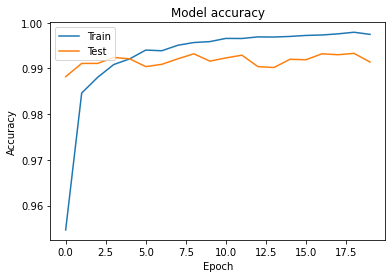

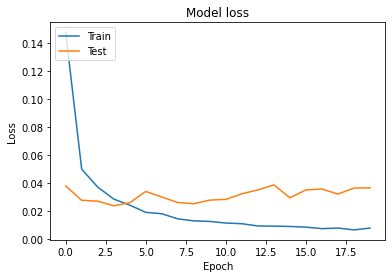

In [72]:
# Plot training accuracy & loss values
plt.plot(range(EPOCHS), history['train_acc'])
plt.plot(range(EPOCHS), history['test_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot test accuracy and loss values
plt.plot(range(EPOCHS), history['train_loss'])
plt.plot(range(EPOCHS), history['test_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save weights to drive

In [73]:
# w0 = model.layers[1].get_weights()[0]
# b0 = model.layers[1].get_weights()[1]
# w1 = model.layers[2].get_weights()[0]
# b1 = model.layers[2].get_weights()[1]

# np.save(F"/content/gdrive/My Drive/w0", w0)
# np.save(F"/content/gdrive/My Drive/b0", b0)
# np.save(F"/content/gdrive/My Drive/w1", w1)
# np.save(F"/content/gdrive/My Drive/b1", b1)